<h1>CS4618: Artificial Intelligence I</h1>
<h1>Training a Neural Network</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp

from tensorflow.keras.datasets.mnist import load_data

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import SGD

from lib.pyimagesearch import LearningRateFinder
from lib.clr_callback import CyclicLR

In [3]:
# MNIST dataset

# Load MNIST into four Numpy arrays
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = load_data()
mnist_x_train = mnist_x_train.reshape((60000, 28 * 28))
mnist_x_test = mnist_x_test.reshape((10000, 28 * 28))

<h1>Acknowledgements</h1>
<ul>
    <li>The <code>LearningRateFinder</code> class comes from Adrian Rosebrock's excellent
        <a href="https://www.pyimagesearch.com/">pyimagesearch</a> site. He credits the
        <a href="http://github.com/amaiya/ktrain">ktrain library</a> for the original code.
    </li>
    <li>The <code>CyclicLR</code> class comes from Brad Kenstler and others:
        <a href="https://github.com/bckenstler/CLR/blob/master/clr_callback.py">https://github.com/bckenstler/CLR/blob/master/clr_callback.py</a>.
    </li>
    <li>They both credit the following paper for both ideas:<br />
        L. N. Smith, "Cyclical Learning Rates for Training Neural Networks," 
        2017 IEEE Winter Conference on Applications of Computer Vision (WACV), 
        Santa Rosa, CA, 2017, pp. 464-472, doi: 10.1109/WACV.2017.58.
    </li>
</ul>

<h1>Introduction</h1>
<ul>
    <li>We'll give an overview of Gradient Descent for neural networks.
        <ul>
            <li>Our goal is to get the 'flavour' of the algorithm.
            </li>
        </ul>
    </li>
    <li>Then, we will discuss the Vanishing Gradients Problem and its solutions.</li>
    <li>Finally, we'll discuss how to choose a learning rate.</li>
</ul>

<h1>Gradient Descent for Neural Networks</h1>
<ul>
    <li>Let's start by reminding ourselves of (Batch) Gradient Descent for OLS regression:
        <ul style="background: lightgrey; list-style: none">
            <li>initialize $\v{\beta}$ randomly
            <li>
                repeat until convergence
                <ul>
                    <li>
                        $\v{\beta} \gets \v{\beta} - \frac{\alpha}{m}\v{X}^T(\v{X}\v{\beta} - \v{y})$
                    </li>
                </ul>
             </li>
        </ul>
    </li>
    <li>We see it making predictions $\hat{\v{y}} = \v{X}\v{\beta}$ for all the examples $\v{X}$ and 
        comparing them with target values, $\v{y}$.
    </li>
    <li>And we see it updating al the parameters $\v{\beta}$ by an amount equal to the negative of
        the gradients, multiplied by the learning rate $\alpha$.
    </li>
</ul>

<h1>Backpropagation</h1>
<ul>
    <li>For neural networks, however, there is a problem.
        <ul>
            <li>At the output layer, we can straightforwardly compute loss: we can get the network's output
                (its predicton) and we have the target value, because the training set is a labeled dataset.
            </li>
            <li>But we cannot straightforwardly compute loss at the hidden layers: we know what outputs their
                neurons produce but we do not know what they should produce (target values). The labeled
                dataset doesn't tell us the target values for hidden layer neurons.
            </li>
        </ul>  
    </li>
    <li>The solution is to assume that each neuron in layer $l$ is responsible for some part of the loss
        of the neurons it is connected to in layer $l+1$. We'll refer to this amount as the 'error signal'.
    </li>
    <li>This leads to the idea of an algorithm that makes two passes through the network:
        <ul>
            <li>a <b>forward pass</b> to make predictions: we feed $\v{X}$ in to the network and then work forwards
                through the network, computing 
                activations layer by layer
                until we reach the output layer;
            </li>
            <li>a <b>backward pass</b> to compute the gradients: we calculate loss at the output layer and then
                work backwards through the network computing error signals layer by layer until we reach the
                input layer.
            </li>
        </ul>
        With these two steps completed, we have all the gradients, so we can update all the weights and biases.
    </li>
    <li>This very informal description helps you see why the calculation of the gradients (and sometimes
        the entire algorithm) is referred to as <b>backpropagation</b> (or just <b>backprop</b>).
    </li>
</ul>

<h2>Demo</h2>
<ul>
    <li>We'll take a look at <a href="http://experiments.mostafa.io/public/ffbpann/">http://experiments.mostafa.io/public/ffbpann/</a></li>
</ul>

<h2>The Backpropagation Algorithm</h2>
<ul>
    <li><b>Random initialization</b>: initialize all weights and biases randomly</li>
    <li><b>Forward propagation</b>: make predictions for all the training examples:
        <ul>
            <li>Layer by layer from from layer 1 to layer $L$:
                <ul>
                    <li>Calculate the inputs to the units in that layer (weighted sums plus biases)</li>
                    <li>Calculate the outputs of the units in that layer (using activation function)</li>
                </ul>
            </li>
        </ul>
    </li>
    <li><b>Backpropagation</b>:
        <ul>
            <li>Calculate the error signals $\Delta$ at layer $L$</li>
            <li>Layer by layer in reverse from layer $L-1$ to layer 1:
                <ul>
                    <li>Calculate the error signals $\Delta$ for the units in that layer</li>
                </ul>
            </li>
        </ul>
    </li>
    <li><b>Update all the weights</b>: 
        $w^{(l)}_{i,j} \gets w^{(l)}_{i,j} - \alpha \times a_i \times \Delta^{(l)}_j$
     </li>
</ul>

<h2>Class exercise</h2>
<ul>
    <li>Back prop starts by initializing weights randomly.
        <ul>
            <li>E.g it was common to use a normal distribution with mean of 0 and standard deviation 
                of, e.g., 0.05.
            </li>
        </ul>
    </li>
    <li>A novice proposes instead to initailize them all to zero.</li>
    <li>Why in general does this not make sense?</li>
</ul>

<h2>The Backpropagation Algorithm (Vectorized)</h2>
<ul>
    <li><b>Random initialization</b>: initialize all weights randomly</li>
    <li><b>Forward propagation</b>:
        <ul>
            <li>Calculate and store $\v{Z}^{(1)} = \v{X}\v{W}^{(1)}$
            <li>Layer by layer from layer $l=1$ to layer $L$:
                <ul>
                    <li>Calculate and store $\v{A}^{(l)} = g^{(l)}(\v{Z}^{(l)})$</li>
                    <li>Calculate $\v{Z}^{(l+1)} = \v{A}^{(l)}\v{W}^{(l+1)}$</li>
                    <li>Calculate and store $\v{G}^{(l)} = g'(\v{Z}^{(l)})^T$</li>
                </ul>
            </li>
        </ul>
    </li>
    <li><b>Backpropagation</b>:
        <ul>
            <li>Calculate $\v{D}^{(L)} = (\v{A}^{(L)} − \v{Y})^T$</li>
            <li>Layer by layer in reverse from layer $l=L-1$ to layer 1:
                <ul>
                    <li>Calculate and store $\v{D}^{(l)} = \v{G}^{(l)} * \v{W}^{(l)}\v{D}^{(l+1)}$</li>
                </ul>
            </li>
        </ul>
    </li>
    <li><b>Update all the weights</b>:
        <ul>
            <li>$\v{W}^{(1)} = \v{W}^{(1)} - \alpha (\v{D}^{(1)}\v{X})^T$</li>
            <li>$\v{W}^{(l)} = \v{W}^{(l)} - \alpha (\v{D}^{(l)}\v{A}^{(l-1)})^T$ for all other values of $l$</li>
        </ul>
    </li>
</ul>

<ul>
    <li>For simplicity (!), I've omitted the biases.</li>
    <li>We can see in this more precise version that some of the things that are calculated on the
        forward pass get stored.
    </li>
    <li>These things can the be used on the backward pass.</li>
    <li>Similarly, some of the things that are calculated on the backward pass get stored.</li>
    <li>These things can then be used to update the weights.</li>
    <li>This makes backprop much more efficient than it otherwise would be.</li>
</ul>

<h2>Autodiff</h2>
<ul>
    <li>Whoa! We have shown the update rules for a <em>particular</em> network and a <em>particular</em> loss function.</li>
    <li>We would get different update rules if we changed:
        <ul>
            <li>the network, e.g. layers other than dense layers (batch normalization layers, convolutional
                layers, etc.); and/or
            </li>
            <li>the loss function.</li>
        </ul>
    </li>
    <li>Happily, we don't have manually to find the partial derivatives all over again.
        <ul>
            <li>Neural networks consist of layers of operations, each with simple, known derivatives.</li>
            <li>Given that the network simply defines a composite function (see previous lecture), the 
                derivatives for the whole network can be obtained automatically by repeated use of the
                <b>chain rule</b>:
                <ul>
                    <li>To differentiate a function of a function, $y = f(g(x))$, let $u = g(x)$ so that 
                        $y = f(u)$, then
                        $$\frac{dy}{dx} = \frac{dy}{du} \times \frac{du}{dx}$$
                    </li>
                </ul>
            </li>
            <li>Hence, modern frameworks such as TensorFlow can compute gradients automatically in the
                backpropagation step.
            </li>
            <li>This is known as <b>autodiff</b> (or, for the way it is used by backprop, <b>reverse mode autodiff</b>).</li>
        </ul>
    </li>
</ul>

<h1>The Vanishing Gradient Problem</h1>
<ul>
    <li>Each weight is updated by an amount proportional to the gradient of the loss function with respect to
        that weight.
    </li>
    <li>But if the gradient is very small, the weight doesn't change much.
        <ul>
            <li>This may prevent the network from converging to a good approximation of
                the target function.
            </li>
        </ul>
    </li>
    <li>We can now see that this is worse for deeper networks.
        <ul>
            <li>The error signal becomes ever smaller as it is backpropagated.</li>
        </ul>
    </li>
    <li>We look at three solutions:
        <ul>
            <li>Non-saturating activation functions;</li>
            <li>Better initialization;</li>
            <li>Batch normalization.</li>
        </ul>
    </li>
</ul>

<h2>Non-Saturating Activation Functions</h2>
<ul>
    <li>Certain activation functions, including the sigmoid function, are one cause of
        the vanishing gradient problem.
    </li>
</ul>

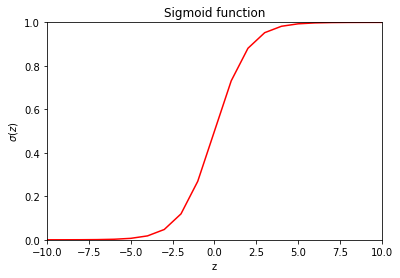

In [4]:
def sigma(z):
    return 1 / (1 + exp(-z))

fig = plt.figure()
plt.title("Sigmoid function")
xvals = np.linspace(-10, 10, 21)
plt.plot(xvals, [sigma(xval) for xval in xvals], color = "red")
plt.xlabel("z")
plt.xlim(-10, 10)
plt.ylabel("$\sigma(z)$")
plt.ylim(0.0, 1.0)
plt.show()

<ul>
    <li>When the input to this function becomes large (positive or negative), the function 
        <b>saturates</b> (i.e. becomes very flat).
        <ul>
            <li>When it saturates, its derivative is extremely close to 0 so there's not much gradient 
                to propagate back to earlier layers (and what little gradient there is
                gets diluted as it propagates back).
            </li>
        </ul>
    </li>
    <li>Even when the gradient is at its greatest (when input $z$ is 0 and $\sigma(z) = 0.5$), it is only 0.25.
        <ul>
            <li>So in the back propagation, gradients always diminish by a quarter or more.</li>
        </ul>
    </li>
    <li>This is why we rarely use the sigmoid function as the activation function in the hidden
        layers of deep networks.
    </li>
    <li>Lots of alternatives have been proposed, including the <b>rectified linear unit</b>
        activation function, ReLU
        $$\mbox{ReLU}(z) = \max(0, z)$$
    </li>
</ul>

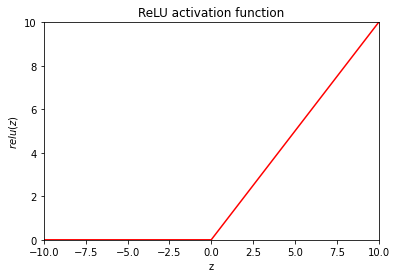

In [5]:
def relu(z):
    return max(z, 0)

fig = plt.figure()
plt.title("ReLU activation function")
xvals = np.linspace(-10, 10, 21)
plt.plot(xvals, [relu(xval) for xval in xvals], color = "red")
plt.xlabel("z")
plt.xlim(-10, 10)
plt.ylabel("$relu(z)$")
plt.ylim(0.0, 10.0)
plt.show()

<ul>
    <li>Neurons that use the ReLU activation function have obvious problems too: 
        <ul>
            <li>If their input (weighted sum) is negative, 
                <ul>
                    <li>the output is zero; and</li>
                    <li>the gradient is zero;</li>
                </ul>
                &mdash; and if this is true for all examples in the training set then, in effect, the neuron dies.
            </li>
            <li>The gradient changes abruptly at $z=0$, which can make Gradient Descent bounce around.
            </li>
        </ul>
    </li>
    <li>Alternatives to ReLU such as Leaky ReLU, ELU (Exponential Linear Unit) and Scaled ELU have been 
        proposed, having  at least some non-zero
        gradient for negative inputs but they are slower to compute and they introduce further hyperparameters.
    </li>
    <li>We'll stick with ReLU in this module. Despite its problems, it remains a popular choice.</li>
</ul>

<h2>Better Random Initialization</h2>
<ul>
    <li>It turns out that vanishing gradients are more likely for certain ways of initializing the weights.</li>
    <li>Perhaps the most typical method was to use a normal distribution with mean of 0 and standard deviation 
        of, e.g., 0.05.
    </li>
    <li>Better methods have been proposed.
        <ul>
            <li>One (of many) is Glorot uniform initialization (also called Xavier uniform initialization).</li>
            <li>Happily, this is the Keras default.</li>
        </ul>
    </li>
</ul>

<h2>Batch Normalization</h2>
<ul>
    <li>We previously studied the usefulness of feature scaling when doing Gradient Descent for,
        e.g., linear regression.
        <figure>
            <img src="images/unscaled.png" style="display: inline" /> 
            <img src="images/scaled.png" style="display: inline" />
        </figure>
        &hellip; and we've been doing this to the features in our neural networks too.
    </li>
    <li>But, if this is a good idea for the inputs to the first hidden layer, why not use the same
        idea for the inputs to subsequent layers?
        <ul>
            <li>In other words, we normalize the activations (outputs) of layer $l$ prior to them being used 
                as inputs to layer $l+1$.
            </li>
            <li>This will control the distribution of the values throughout the training process.</li>
        </ul>
     </li>
     <li>This, in essence, is the idea of <b>batch normalization</b>.</li>
</ul>

<h3>Some of the details</h3>
<ul>
    <li>(No need to learn these details &mdash; and there are some notation abuses anyway!)</li>
    <li>In summary, for a given layer, it standardizes the outputs of the neurons (subtract the mean, divide by
        the standard deviation), then it scales the result and adds an offset.
    </li>
    <li>It standardizes the output of a previous activation layer by subtracting the batch mean and dividing
        by the batch standard deviation:
        <ul>
            <li>Let $B$ be the batch of examples of size $m_B$.</li>
            <li>The mean of a batch of activation values $\mu_B = \frac{1}{m_B}\sum_{i=1}^{m_B} a^{(i)}$.</li>
            <li>Their standard deviation $\sigma^2_B = \frac{1}{m_B}\sum_{i=1}^{m_B}(a^{(i)} - \mu_B)^2$.</li>
            <li>Standardize them: $a^{(i)}_{\mbox{norm}} = \frac{a^{(i)} - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}$,
                where
                $\epsilon$ is a small value to avoid division-by-zero problems.
            </li>
        </ul>
    </li>
    <li>But, while we want the different units to have comparable activation values (achieved by
        standardizing), we don't necessarily want them to have mean 0 and standard deviation 1.
    </li>
    <li>So, we multiply by a scaling factor for the layer and add an offset for the layer.
        <ul>
            <li>Scale and add offset: $\tilde{a}^{(i)} = \gamma a^{(i)}_{\mbox{norm}} + \beta$
            <li>$\gamma$ and $\beta$ are parameters and so they are also learned by the Gradient Descent.</li>
        </ul>
    </li>
</ul>

<h3>Other benefits of Batch Normalization</h3>
<ul>
    <li>Batch Normalization reduces the vanishing gradients problem so much, we can even use saturating
        activation functions.
    </li>
    <li>Training becomes less sensitive to the method used for randomly initializing weights.</li>
    <li>Much larger learning rates work (faster convergence) with less risk of divergence.</li>
    <li>It acts like a regularizer.</li>
</ul>

<h3>Batch normalization in Keras</h3>
<ul>
    <li>Just add another layer!</li>
    <li>E.g.
        <pre>
x = Dense, 12, activation="relu")(x)
x = BatchNormalization()(x)
        </pre>
        This is how we will do batch normalization in CS4618.
    </li>
    <li>Ignore: in fact, there is some debate about whether we should batch 
         normalize the activations of
        the layer (as above) or the weighted sum, before applying the activation function (as below):
        <pre>
x = Dense, 12, activation="linear")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
        </pre>
        We'll stick with the former, which is more concise.
    </li>
</ul>

<h2>Exploring Vanishing Gradients with MNIST</h2>

In [6]:
def build_mnist_network(activation, initializer, use_batch_norm):
    inputs = Input(shape=(28 * 28,))
    x = Rescaling(scale=1./255)(inputs)
    x = Dense(512, activation=activation, kernel_initializer=initializer)(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    outputs = Dense(10, activation="softmax", kernel_initializer=initializer)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=SGD(learning_rate=0.01), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
networks = [
    build_mnist_network("sigmoid", "random_normal", False),
    build_mnist_network("sigmoid", "random_normal", True),
    build_mnist_network("sigmoid", "glorot_uniform", False),
    build_mnist_network("sigmoid", "glorot_uniform", True),
    build_mnist_network("relu", "random_normal", False),
    build_mnist_network("relu", "random_normal", True),
    build_mnist_network("relu", "glorot_uniform", False),
    build_mnist_network("relu", "glorot_uniform", True)
]

for network in networks:
    network.fit(mnist_x_train, mnist_y_train, epochs=10, batch_size=32, verbose=0)
    test_loss, test_acc = network.evaluate(mnist_x_test, mnist_y_test, verbose=0)
    print(test_acc)

2021-08-12 17:09:52.544682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-12 17:09:52.750904: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


0.9110999703407288
0.932200014591217
0.9121999740600586
0.9322999715805054
0.9539999961853027
0.9778000116348267
0.9563999772071838
0.98089998960495


<ul>
    <li>We shouldn't read too much into the results above.
        The ideas in this lecture apply to <em>deep</em> networks.
        This network is not deep.
    </li>
</ul>

<h1>Learning Rate</h1>
<ul>
    <li>Among many hyperparameters, perhaps the most important is the learning rate.
        <ul>
            <li>This can affect whether training converges or diverges.</li>
            <li>By changining the learning rate using a <b>learning rate schedule</b> (as we do in
                <b>simulated annealing</b>), we can improve convergence of SGD and 
                Mini-Batch GD, and maybe avoid getting stuck in some local minima.
            </li>
        </ul>
    </li>
    <li>Here we'll discuss two things: (a) one way to choose a learning rate and (b) one
        learning schedule.
    </li>
    <li>The techniques we look at have been popularized by their use in the online
        <a href="https://www.fast.ai/">FastAI course</a>.
    </li>
</ul>

<h2>Plotting loss</h2>
<ul>
    <li>Two notes about the Keras <code>fit</code> method:
        <ul>
            <li>We can specify a validation dataset (<code>validation_data</code>) or request that
                the dataset be split (<code>validation_split</code>).
            </li>
            <li>It returns a <code>History</code> object whose <code>history</code> attribute
                records, for each epoch, the training losses and validation losses, and also the
                values for any metrics requested in the <code>compile</code> method.
            </li>
        </ul>
    </li>
    <li>So we can choose a learning rate and plot losses. 
        <ul>
            <li>If loss comes down too slowly, the learning rate may be too small.</li>
            <li>If loss starts to go up, then the learning rate may be too large (divergence).</li>
        </ul>
    </li>
</ul>           

In [8]:
def build_mnist_model():
    inputs = Input(shape=(28 * 28,))
    x = Rescaling(scale=1./255)(inputs)
    x = Dense(512, activation="relu")(x)
    outputs = Dense(10, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=SGD(learning_rate=0.01), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [9]:
mnist_model = build_mnist_model()

history = mnist_model.fit(mnist_x_train, mnist_y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=0)

<ul>
    <li>We can plot training error and validation error (loss) on the $y$-axis and epochs on the $x$-axis
        to see our progress.
    </li>
    <li>We will call this kind of plot a <b>training curve</b>.
        <ul>
            <li>How do the $x$-axes differ in a <b>validation curve</b>, <b>learning curve</b>
                and <b>training curve</b>?
            </li>
            <li>What is each used for?</li>
        </ul>
    </li>
 </ul>

<AxesSubplot:>

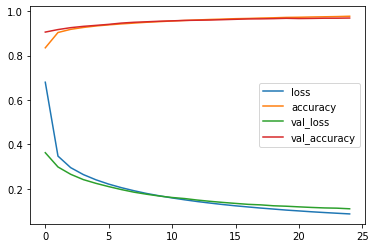

In [10]:
pd.DataFrame(history.history).plot()

<ul>
    <li>(There is an explanaton for why validation loss can be initially lower than training loss: they are
        half an epoch out-of-step.)
    </li>
    <li>Here, SGD's default learning rate seems OK.</li>
    <li>If it weren't, we could change it, retrain and re-plot.</li>
    <li>But this is hit-and-miss. One alternative is grid search or randomized search, but these are 
        expensive.
    </li>
</ul>

<h2>Finding a learning rate</h2>
<ul>
    <li>A popular alternative to hit-and-miss and grid search/randomized search is:
        <ul>
            <li>Train for just a few epochs, e.g. 5.</li>
            <li>Start with a very low learning rate (e.g. 1e-10), then a  higher one, 
                then a higher one, and so on up to some high value (e.g. 10).
            </li>
            <li>Change the learning rate after each <em>batch</em>.</li>
            <li>Plot the loss ($y$-axis) against learning rate ($x$-axis).</li>
            <li>You should see loss decreasing slowly, then dropping sharply, and then increasing
                sharply.
            </li>
            <li>The best learning rate is just before loss starts to rise: rule-of-thumb is 10 times
                smaller than the bottom.
            </li>
        </ul>
        From now on, use this as your learning rate.
    </li>
</ul>   

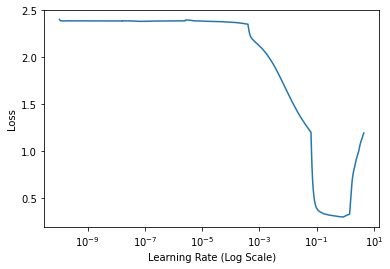

In [11]:
mnist_model = build_mnist_model()

lr_finder = LearningRateFinder(mnist_model)

lr_finder.find(trainData=(mnist_x_train, mnist_y_train), 
               startLR=1e-10, endLR=1e+1, 
               epochs=5, batchSize=32, verbose=0)

lr_finder.plot_loss(skipBegin=10, skipEnd=1, title="")

<ul>
    <li>SGD's default is 10e-1, and this seems to be recommending 10e-1 or 10e-2 (it can vary from
        run to run).
    </li>
    <li>Of course, the learning rate is only one hyperparameter. Keras now offers something
        called KearTuner (requires a separate install), which can help you automatically find
        hyperparameter values (similar, but not identical to scikit-learn's grid search). 
        As you can imagine, tuning the hyperparameters of deep neural networks is very expensive!
    </li>
</ul>

<h2>1cycle scheduling</h2>
<ul>
    <li>If an optimizer uses a learning rate schedule, then most likely the schedule reduces the
        learning rate over time.
    </li>
    <li>But reducing the learning rate may nevertheless leave us stuck on plateaus or in local minima.</li>
    <li>1cycle scheduling, popularized by FastAI, uses two learning rates:
        <ul>
            <li>minimum learning rate; and</li>
            <li>maximum learning rate.</li>
            Simply, we change the learning rate after every batch: it grows from minimum to maximum,
            then from maximum to minimum, then from
            minimum to maximum, and so on.
        </ul>
    </li>
    <li>What should you use as the minimum and maximum learning rates?
        <ul>
            <li>One suggestion is to use the plot from the learning rate finder above: just after it starts
                falling, and just before it starts growing.
            </li>
        </ul>
    </li>
</ul>

In [12]:
mnist_network = build_mnist_model()

batch_size = 32
step_size = 6 * mnist_x_train.shape[0] // 32

clr = CyclicLR(base_lr=10e-3, max_lr=10e-1, step_size=step_size)

history = mnist_model.fit(mnist_x_train, mnist_y_train, epochs=25, batch_size=batch_size, validation_split=0.2, 
                          callbacks=[clr], verbose=0)

<ul>
    <li>The recommendation is that <code>step_size</code> is some multiple of (e.g. $6\times$) the number of
        batches per epoch.
    </li>
</ul>

In [13]:
test_loss, test_acc = mnist_model.evaluate(mnist_x_test, mnist_y_test)
test_acc

313/313 [==============================] - 1s 2ms/step - loss: 0.0898 - accuracy: 0.9837


0.9836999773979187

<AxesSubplot:>

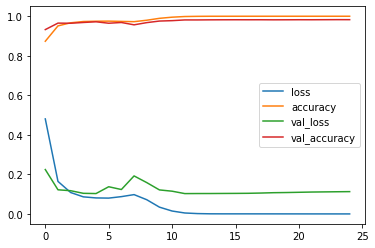

In [14]:
pd.DataFrame(history.history).plot()

<ul>
    <li>We can even see how the learning rate changes:</li>
</ul>

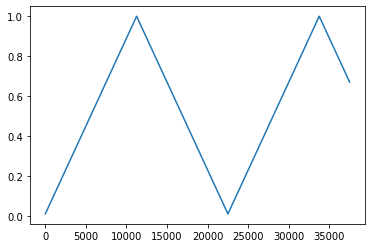

In [15]:
plt.plot(clr.history["lr"])